# **모델 1 모델링**
### 🧑‍💻 가은

- MultiOutputRegressor(GradientBoostingRegressor())
- MultiOutputRegressor(HistGradientBoostingRegressor())

---

### 🧑‍💻 아현

- MultiOutputRegressor(XGBRegressor())
- MultiOutputRegressor(CatBoostRegressor())

---

### 성능 분석 지표
- MAE
- MSE
- RMSE
- R² Score

# Contents

I. Train and Test Data Loading

II. Model Definition & Training

III. Inference on Test Set

# 가은

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.2 MB/s eta 0:00:00


In [3]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_hist_gradient_boosting  # 필요 시 활성화
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Train and Test Data Loading

### Data Loading

In [4]:
# mount our Google Drive into the Colab environment
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os

root_dir = "/content/gdrive/MyDrive/Data Science Team Project" # Please put your directory here

# Checking if our specified directory exists
os.path.exists(root_dir)

True

In [6]:
# Specify the file name
train_file = "Data1_Train.csv"

# Load the dataset using pandas
train_set = pd.read_csv(os.path.join(root_dir, train_file))

In [7]:
# 'YEAR' 컬럼 기준으로 스플릿
train_df = train_set[train_set['YEAR'] <= 2014].reset_index(drop=True)
val_df   = train_set[train_set['YEAR'] >= 2015].reset_index(drop=True)

# 결과 확인 (행 수 출력)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# 필요시 저장
# train_set.to_csv("train_set.csv", index=False)
# val_set.to_csv("val_set.csv", index=False)

Train set size: 540
Validation set size: 60


In [8]:
# 입력 컬럼: 'YEAR' + 'MONTH_1' ~ 'MONTH_12'
month_cols = [col for col in train_df.columns if col.startswith("MONTH_")]
input_cols = ['YEAR'] + month_cols

# 타겟 컬럼 정의
target_cols = ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'temp_range', 'daily_precip']

# X, y 생성
X_train = train_df[input_cols]
y_train = train_df[target_cols]
X_val   = val_df[input_cols]
y_val   = val_df[target_cols]

## Model Definition & Training

### 1. MultiOutputRegressor(GradientBoostingRegressor())

In [9]:
# Optuna 목적 함수 정의 (전체 타깃 MAE 평균 최소화)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', None]),
        'random_state': 42
    }

    base_model = GradientBoostingRegressor(**params)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)

    # 다중 타깃 MAE 평균 계산
    mae_list = [mean_absolute_error(y_val.iloc[:, i], val_pred[:, i]) for i in range(len(target_cols))]
    mean_mae = np.mean(mae_list)
    return mean_mae

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # n_trials는 필요에 따라 조정

print("Best hyperparameters found:")
print(study.best_params)

# 최적 파라미터로 최종 모델 학습
best_params = study.best_params
best_params['random_state'] = 42
final_base_model = GradientBoostingRegressor(**best_params)
final_model = MultiOutputRegressor(final_base_model)
final_model.fit(X_train, y_train)

# 최종 예측
y_pred = final_model.predict(X_val)

[I 2025-05-28 07:24:16,144] A new study created in memory with name: no-name-8f1677ba-3737-4be7-b6b1-823051e1d7e1
<ipython-input-9-d6a00c66d0a6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2025-05-28 07:24:20,296] Trial 0 finished with value: 1.3395358844251068 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.013535242203267185, 'subsample': 0.8, 'max_features': None}. Best is trial 0 with value: 1.3395358844251068.
<ipython-input-9-d6a00c66d0a6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2

Best hyperparameters found:
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.09905667134008762, 'subsample': 0.8, 'max_features': 'sqrt'}


**전체 성능 지표 출력**

In [10]:
def evaluate_multitarget_overall(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred, multioutput='uniform_average')
    mse = mean_squared_error(y_true, y_pred, multioutput='uniform_average')
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
    adjusted_r2 = 1 - r2

    print(f"[{dataset_name} 전체 모델 성능 평가]")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f} (1 - R² = {adjusted_r2:.4f})")

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        '1 - R2': adjusted_r2
    }

# 사용 예시
results1 = evaluate_multitarget_overall(y_val, y_pred, "Validation")

[Validation 전체 모델 성능 평가]
MAE : 0.9439
MSE : 2.0929
RMSE: 1.4467
R²  : 0.6500 (1 - R² = 0.3500)


**Feature별 지표 출력**

In [11]:
# 각 지표 계산
mae = mean_absolute_error(y_val, y_pred, multioutput='raw_values')
mse = mean_squared_error(y_val, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred, multioutput='raw_values')

# 결과 출력
for i, col in enumerate(target_cols):
    print(f"▶ {col}")
    print(f"   MAE : {mae[i]:.4f}")
    print(f"   MSE : {mse[i]:.4f}")
    print(f"   RMSE: {rmse[i]:.4f}")
    print(f"   R²   : {r2[i]:.4f}")
    print("-" * 30)

▶ MAX_TEMP
   MAE : 1.0642
   MSE : 1.8992
   RMSE: 1.3781
   R²   : 0.9763
------------------------------
▶ MIN_TEMP
   MAE : 1.0795
   MSE : 1.8846
   RMSE: 1.3728
   R²   : 0.9787
------------------------------
▶ AVG_WIND_SPEED
   MAE : 0.1417
   MSE : 0.0362
   RMSE: 0.1903
   R²   : 0.6831
------------------------------
▶ temp_range
   MAE : 0.9745
   MSE : 1.6722
   RMSE: 1.2931
   R²   : 0.4734
------------------------------
▶ daily_precip
   MAE : 1.4596
   MSE : 4.9726
   RMSE: 2.2299
   R²   : 0.1387
------------------------------


#### Validation set의 정답과 예측 결과 비교

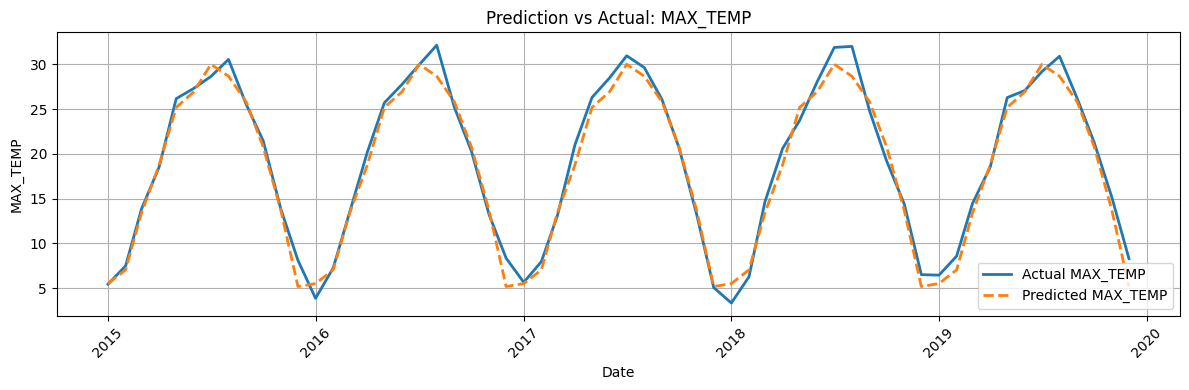

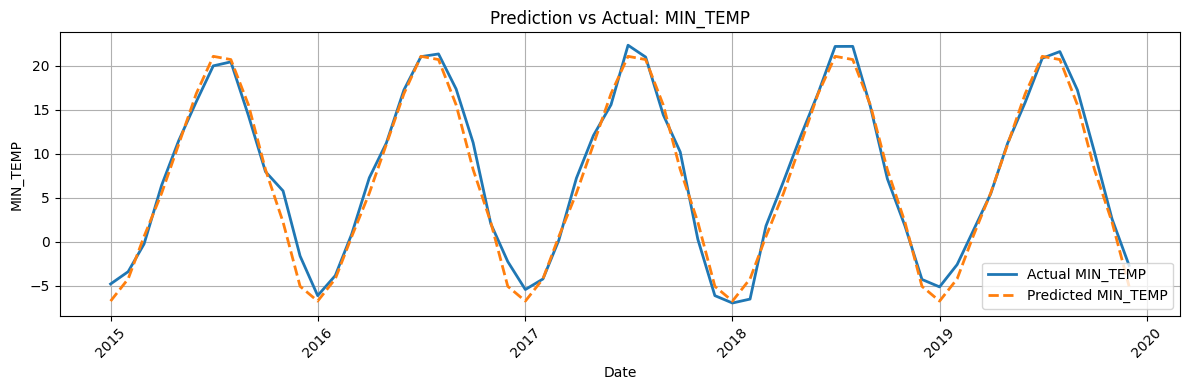

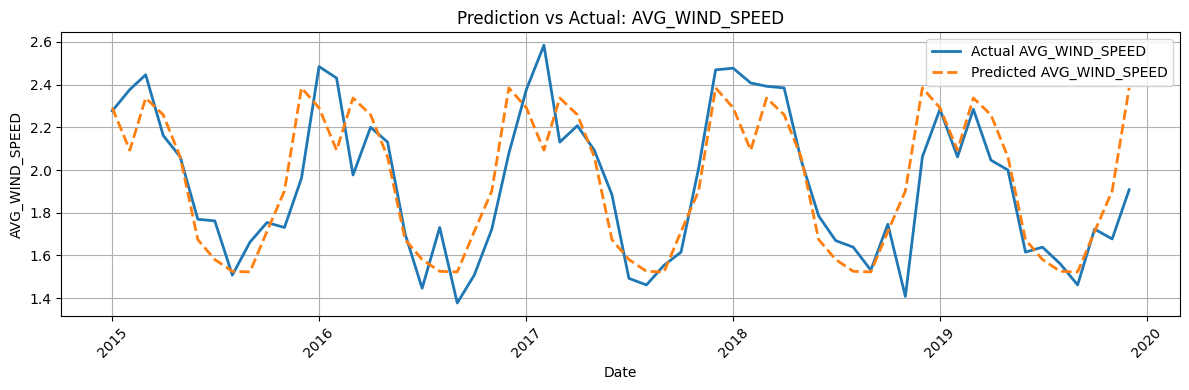

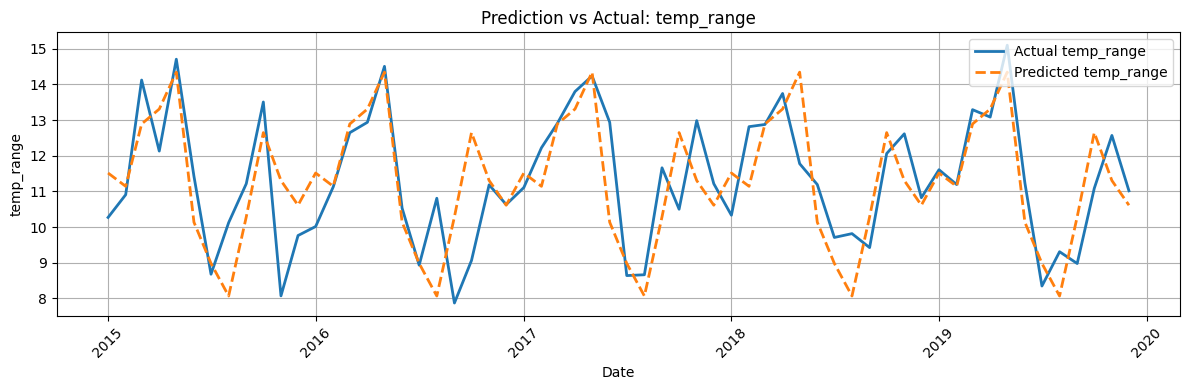

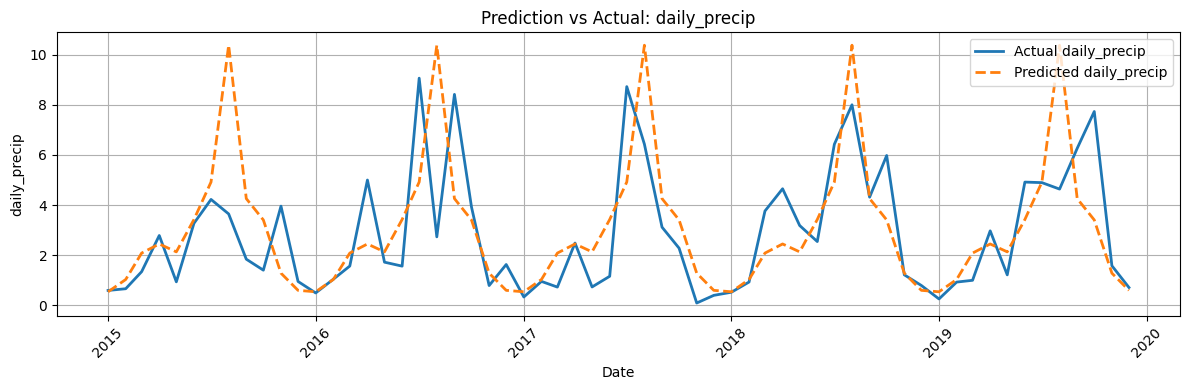

In [12]:
# 타겟 컬럼들
target_cols = ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'temp_range', 'daily_precip']

# 원핫 인코딩된 MONTH 정보 → 정수형 MONTH 값으로 변환
val_df = val_df.copy()
val_df['MONTH'] = val_df[[f'MONTH_{i}' for i in range(1, 13)]].idxmax(axis=1).str.extract('(\d+)').astype(int)

# 'YEAR-MONTH' 형식 문자열 생성 → datetime 변환 → 시간 정렬 기준으로 사용
val_df['DATE'] = pd.to_datetime(val_df['YEAR'].astype(str) + '-' + val_df['MONTH'].astype(str) + '-01')
val_df_sorted = val_df.sort_values('DATE').reset_index(drop=True)

# y_val 및 y_pred_df도 정렬
y_val_sorted = y_val.loc[val_df_sorted.index].reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=target_cols)
y_pred_sorted = y_pred_df.loc[val_df_sorted.index].reset_index(drop=True)

# 시각화
plt.rcParams['figure.figsize'] = (12, 4)

for col in target_cols:
    plt.figure()
    plt.plot(val_df_sorted['DATE'], y_val_sorted[col], label=f'Actual {col}', linewidth=2)
    plt.plot(val_df_sorted['DATE'], y_pred_sorted[col], label=f'Predicted {col}', linestyle='--', linewidth=2)
    plt.title(f'Prediction vs Actual: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 마지막에 MONTH 컬럼 제거
val_df.drop(columns=['MONTH'], inplace=True)

### MultiOutputRegressor(HistGradientBoostingRegressor())

In [13]:
def objective(trial):
    params = {
        'max_iter': trial.suggest_categorical('max_iter', [100, 200, 300]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 10]),
        'l2_regularization': trial.suggest_categorical('l2_regularization', [0.0, 1.0, 5.0]),
        'random_state': 42
    }

    base_model = HistGradientBoostingRegressor(**params)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)

    mae_list = [mean_absolute_error(y_val.iloc[:, i], val_pred[:, i]) for i in range(len(target_cols))]
    return np.mean(mae_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best params found:")
print(study.best_params)

best_params = study.best_params
best_params['random_state'] = 42

final_base_model = HistGradientBoostingRegressor(**best_params)
final_model = MultiOutputRegressor(final_base_model)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_val)

[I 2025-05-28 07:24:49,147] A new study created in memory with name: no-name-47439fb6-a5b0-459a-ad81-3fc9f2384c24
<ipython-input-13-cbabcd7e1a49>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2025-05-28 07:24:50,382] Trial 0 finished with value: 0.8891280646683842 and parameters: {'max_iter': 300, 'learning_rate': 0.05209923885669641, 'max_depth': 5, 'l2_regularization': 1.0}. Best is trial 0 with value: 0.8891280646683842.
<ipython-input-13-cbabcd7e1a49>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2025-05-28 07:24:5

Best params found:
{'max_iter': 200, 'learning_rate': 0.09114319688810846, 'max_depth': 10, 'l2_regularization': 1.0}


**전체 성능 지표 출력**

In [14]:
# evaluate_multitarget 함수 호출하여 평가 출력 및 결과 저장
results2 = evaluate_multitarget_overall(y_val, y_pred, "Validation")

[Validation 전체 모델 성능 평가]
MAE : 0.8865
MSE : 1.6893
RMSE: 1.2997
R²  : 0.7071 (1 - R² = 0.2929)


**Feature별 지표 출력**

In [15]:
# 예측 및 평가
mae = mean_absolute_error(y_val, y_pred, multioutput='raw_values')
mse = mean_squared_error(y_val, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred, multioutput='raw_values')

for i, col in enumerate(target_cols):
    print(f"▶ {col}")
    print(f"   MAE : {mae[i]:.4f}")
    print(f"   MSE : {mse[i]:.4f}")
    print(f"   RMSE: {rmse[i]:.4f}")
    print(f"   R²   : {r2[i]:.4f}")
    print("-" * 30)

▶ MAX_TEMP
   MAE : 0.9981
   MSE : 1.4928
   RMSE: 1.2218
   R²   : 0.9814
------------------------------
▶ MIN_TEMP
   MAE : 1.0352
   MSE : 1.7590
   RMSE: 1.3263
   R²   : 0.9801
------------------------------
▶ AVG_WIND_SPEED
   MAE : 0.1462
   MSE : 0.0367
   RMSE: 0.1917
   R²   : 0.6785
------------------------------
▶ temp_range
   MAE : 0.9191
   MSE : 1.4913
   RMSE: 1.2212
   R²   : 0.5304
------------------------------
▶ daily_precip
   MAE : 1.3337
   MSE : 3.6666
   RMSE: 1.9148
   R²   : 0.3649
------------------------------


#### Validation set의 정답과 예측 결과 비교

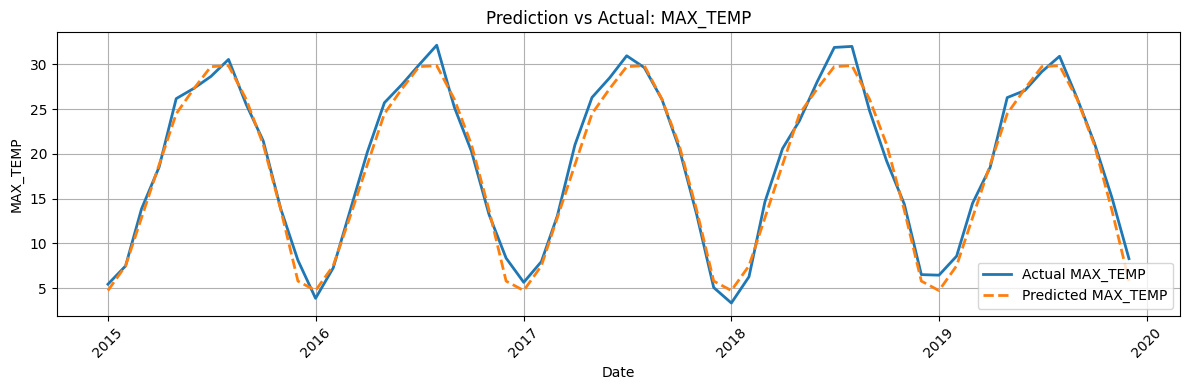

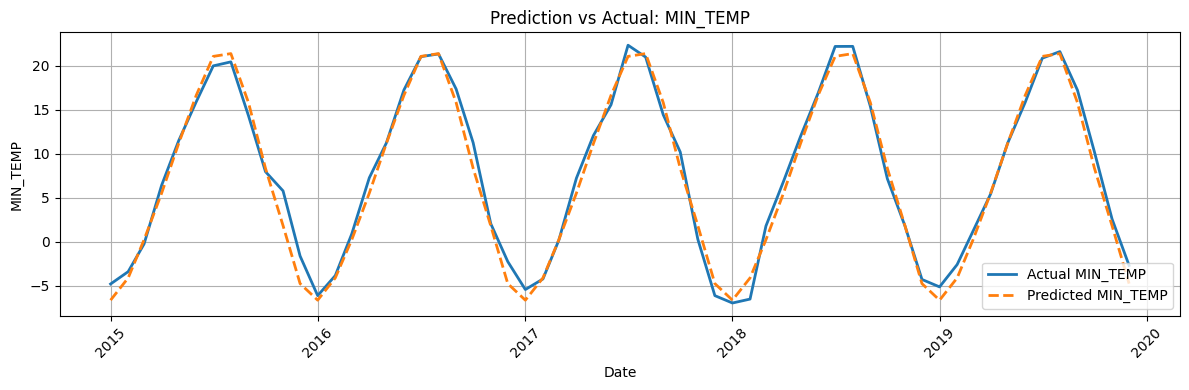

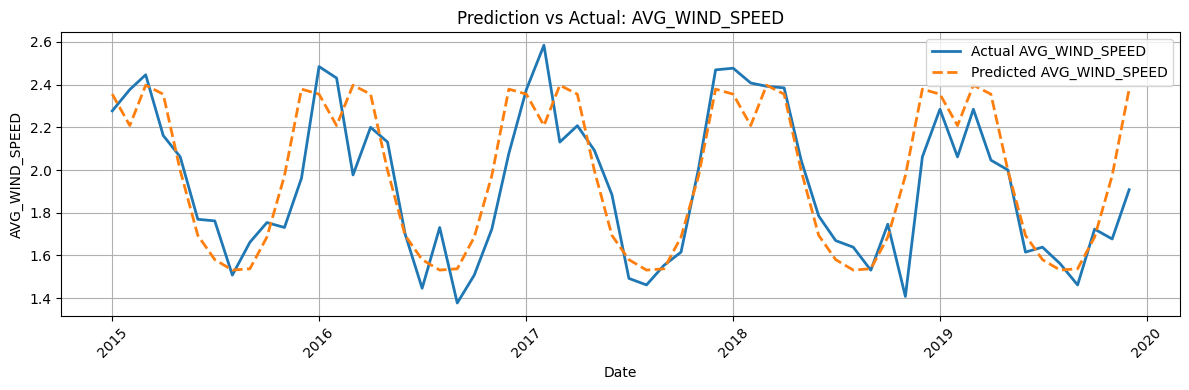

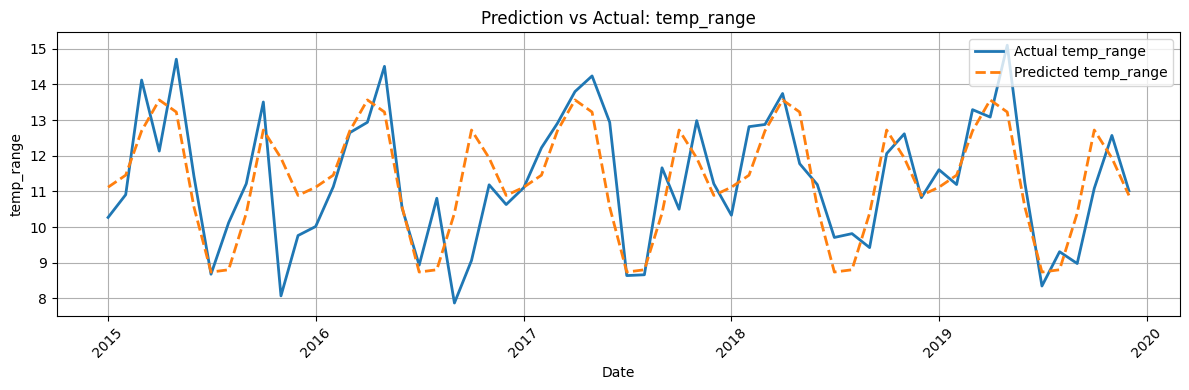

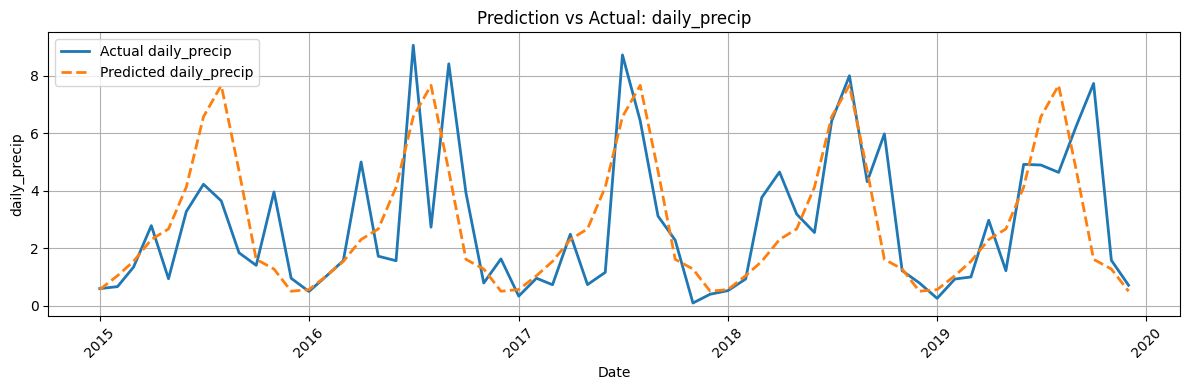

In [16]:
# 월 정수형 값 생성
val_df = val_df.copy()
val_df['MONTH'] = val_df[[f'MONTH_{i}' for i in range(1, 13)]].idxmax(axis=1).str.extract('(\d+)').astype(int)

# DATE 컬럼 생성 및 정렬
val_df['DATE'] = pd.to_datetime(val_df['YEAR'].astype(str) + '-' + val_df['MONTH'].astype(str) + '-01')
val_df_sorted = val_df.sort_values('DATE').reset_index(drop=True)

# 정렬된 y_val, y_pred 생성
y_val_sorted = y_val.loc[val_df_sorted.index].reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=target_cols)
y_pred_sorted = y_pred_df.loc[val_df_sorted.index].reset_index(drop=True)

# 시각화
plt.rcParams['figure.figsize'] = (12, 4)

for col in target_cols:
    plt.figure()
    plt.plot(val_df_sorted['DATE'], y_val_sorted[col], label=f'Actual {col}', linewidth=2)
    plt.plot(val_df_sorted['DATE'], y_pred_sorted[col], label=f'Predicted {col}', linestyle='--', linewidth=2)
    plt.title(f'Prediction vs Actual: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 정리: MONTH 컬럼 제거
val_df.drop(columns=['MONTH'], inplace=True)